# Running/Importing .py files with Colab  

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Access my google drive

Install Keras

In [ ]:
!pip install -q keras

# Get the Class Names

Below file contains a subset of the quick draw classes (around 100 classes)

In [ ]:
!wget 'https://raw.githubusercontent.com/clh7782/tfjs_sketcher/master/mini_classes.txt'

--2023-07-24 07:17:40--  https://raw.githubusercontent.com/clh7782/tfjs_sketcher/master/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 860 [text/plain]
Saving to: ‘mini_classes.txt.2’

mini_classes.txt.2  100%[===================>]     860  --.-KB/s    in 0s      

2023-07-24 07:17:40 (66.5 MB/s) - ‘mini_classes.txt.2’ saved [860/860]



Read the class names


In [ ]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

# Download the dataset

Loop over the classes and download correspondent data

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
import urllib.request
def download():

  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [ ]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums
.npy


InvalidURL: ignored

# Imports

In [ ]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

# Load the data

Load 5000 images per class

In [ ]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [ ]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [ ]:
print(len(x_train))

320000


spider


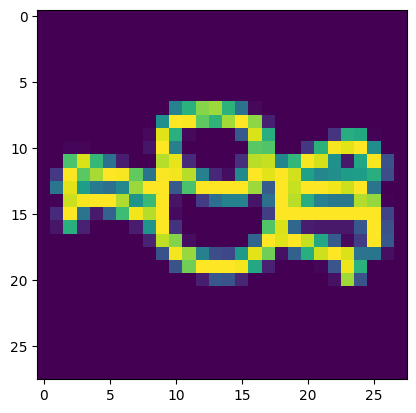

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

# Preprocess the data

In [ ]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model

In [ ]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

# Training

In [ ]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
1125/1125 - 12s - loss: 1.9411 - top_k_categorical_accuracy: 0.7801 - val_loss: 1.3845 - val_top_k_categorical_accuracy: 0.8789 - 12s/epoch - 11ms/step
Epoch 2/5
1125/1125 - 7s - loss: 1.2507 - top_k_categorical_accuracy: 0.8924 - val_loss: 1.1713 - val_top_k_categorical_accuracy: 0.9027 - 7s/epoch - 6ms/step
Epoch 3/5
1125/1125 - 5s - loss: 1.0878 - top_k_categorical_accuracy: 0.9096 - val_loss: 1.0693 - val_top_k_categorical_accuracy: 0.9118 - 5s/epoch - 5ms/step
Epoch 4/5
1125/1125 - 5s - loss: 0.9968 - top_k_categorical_accuracy: 0.9193 - val_loss: 0.9898 - val_top_k_categorical_accuracy: 0.9198 - 5s/epoch - 5ms/step
Epoch 5/5
1125/1125 - 7s - loss: 0.9348 - top_k_categorical_accuracy: 0.9252 - val_loss: 0.9734 - val_top_k_categorical_accuracy: 0.9219 - 7s/epoch - 6ms/step


# Testing

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 92.09%


# Inference

1/1 [==============================] - 0s 180ms/step
['umbrella', 'hammer', 'axe', 'traffic_light', 'microphone']


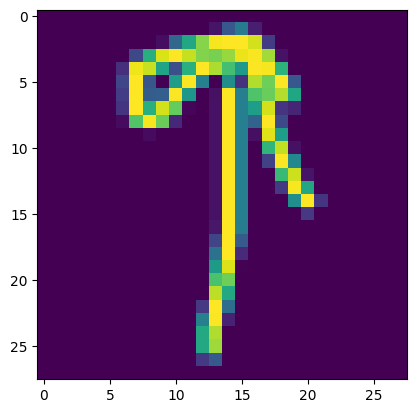

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the Classes

In [ ]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [ ]:
!pip install tensorflowjs

# Save and Convert

In [ ]:
model.save('keras.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

mkdir: cannot create directory ‘model’: File exists
2023-07-24 08:31:03.049257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Zip and Download

In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/model.json (deflated 82%)
  adding: model/group1-shard1of1.bin (deflated 7%)
  adding: model/class_names.txt (deflated 41%)


In [ ]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>